In [1]:
# pip install pyfolio
# pip install nbformat

In [2]:
# Selecting libraries
import nbformat
import yfinance as yf
import pandas as pd
import numpy as np
import pyfolio as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
warnings.filterwarnings("ignore")

c:\Users\josh\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyfolio\pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


| Variable                  | Description                     |
|---------------------------|---------------------------------|
| Date                     | Date of the data points        |
| PX_LAST                   | Last Price                      |
| PX_BID                    | Bid Price                       |
| LAST_PRICE                | Last Trade/Last Price           |
| PX_ASK                    | Ask Price                       |
| PX_MID                    | Mid Price                       |
| CHG_PCT_1D                | Price Change 1 Day Percent      |
| CUR_MKT_CAP               | Current Market Cap              |
| PX_CLOSE_1D               | Closing Price 1 Day Ago         |

In [3]:
equity = pd.read_csv('./Cleaned_Data/SPX.csv')
highyield = pd.read_csv('./Cleaned_Data/highyield.csv')
safebond = pd.read_csv('./Cleaned_Data/safebond.csv')

equity['Dates'] = pd.to_datetime(equity['Dates'])
highyield['Dates'] = pd.to_datetime(highyield['Dates'])
safebond['Dates'] = pd.to_datetime(safebond['Dates'])

### No Rebalancing - Buy and Hold

Synthetic Portfolio Analysis using index returns

In [4]:
# Define portfolio allocations
allocations_A = {'Equities': 0.50, 'HighYieldBonds': 0.00, 'InvGradeBonds': 0.50}
allocations_B = {'Equities': 0.40, 'HighYieldBonds': 0.10, 'InvGradeBonds': 0.50}
allocations_C = {'Equities': 0.50, 'HighYieldBonds': 0.10, 'InvGradeBonds': 0.40}
allocations_D = {'Equities': 0.45, 'HighYieldBonds': 0.10, 'InvGradeBonds': 0.45}

# Create a DataFrame using the allocation variables
allocations_df = pd.DataFrame({
    'Asset': ['Equities', 'HighYieldBonds', 'InvGradeBonds'],
    'Index': ['SPX', 'Bloomberg HighYield', 'Bloomberg Agg'],
    'Baseline': [allocations_A['Equities'], allocations_A['HighYieldBonds'], allocations_A['InvGradeBonds']],
    'JS_Strategy': [allocations_B['Equities'], allocations_B['HighYieldBonds'], allocations_B['InvGradeBonds']],
    'JB_Strategy': [allocations_C['Equities'], allocations_C['HighYieldBonds'], allocations_C['InvGradeBonds']],
    'JE_Strategy': [allocations_D['Equities'], allocations_D['HighYieldBonds'], allocations_D['InvGradeBonds']]
})
allocations_df

,Asset,Index,Baseline,JS_Strategy,JB_Strategy,JE_Strategy
0,Equities,SPX,0.5,0.4,0.5,0.45
1,HighYieldBonds,Bloomberg HighYield,0.0,0.1,0.1,0.10
2,InvGradeBonds,Bloomberg Agg,0.5,0.5,0.4,0.45


I think the name for JS: equity is SMALLER; JB: equity is BIGGER; JE: equity and safe bond are EQUAL

In [5]:
start_date = '1983-08-01'
end_date = '2024-06-25'

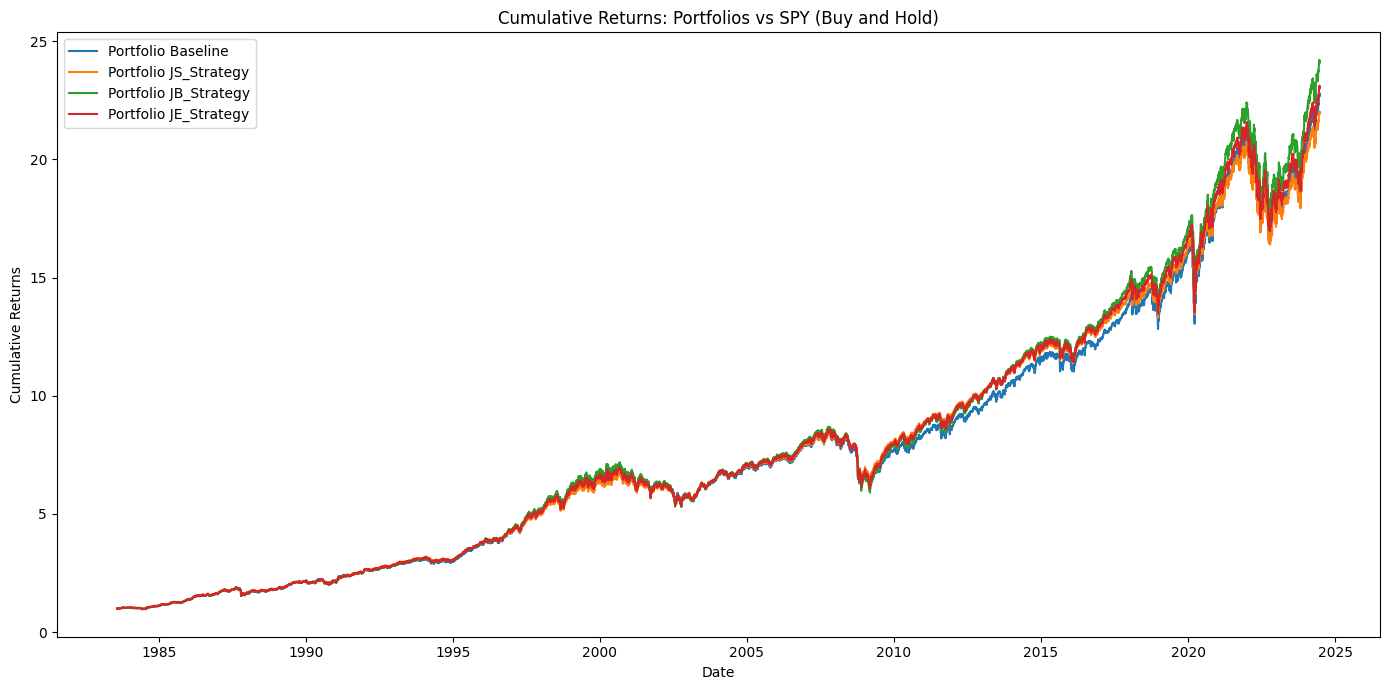

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function with SPY as benchmark for buy-and-hold strategy
def backtest_portfolios_buy_and_hold(allocations_df, backtest_start_date, backtest_end_date, spy=equity, jnk=highyield, agg=safebond):
    cumulative_product_dict = {}

    for allocation_name in allocations_df.columns[2:]:  # Skip 'Asset' and 'Index' columns
        # Extract the allocation values from allocations_df
        allocations = {
            'Equities': allocations_df.loc[allocations_df['Asset'] == 'Equities', allocation_name].values[0],
            'HighYieldBonds': allocations_df.loc[allocations_df['Asset'] == 'HighYieldBonds', allocation_name].values[0],
            'InvGradeBonds': allocations_df.loc[allocations_df['Asset'] == 'InvGradeBonds', allocation_name].values[0]
        }

        # Filter the data for the backtest period
        agg_backtest = agg[(agg['Dates'] >= backtest_start_date) & (agg['Dates'] <= backtest_end_date)].set_index('Dates')
        jnk_backtest = jnk[(jnk['Dates'] >= backtest_start_date) & (jnk['Dates'] <= backtest_end_date)].set_index('Dates')
        spy_backtest = spy[(spy['Dates'] >= backtest_start_date) & (spy['Dates'] <= backtest_end_date)].set_index('Dates')

        # Align the indices
        combined_index = agg_backtest.index.intersection(jnk_backtest.index).intersection(spy_backtest.index)
        agg_backtest = agg_backtest.loc[combined_index]
        jnk_backtest = jnk_backtest.loc[combined_index]
        spy_backtest = spy_backtest.loc[combined_index]

        # Calculate cumulative returns for each asset
        agg_cum_returns = (1 + agg_backtest['DailyReturn']).cumprod()
        jnk_cum_returns = (1 + jnk_backtest['DailyReturn']).cumprod()
        spy_cum_returns = (1 + spy_backtest['DailyReturn']).cumprod()

        # Calculate portfolio cumulative returns based on initial allocation
        portfolio_cumulative_product = (
            allocations['Equities'] * spy_cum_returns +
            allocations['HighYieldBonds'] * jnk_cum_returns +
            allocations['InvGradeBonds'] * agg_cum_returns
        )
        cumulative_product_dict[allocation_name] = portfolio_cumulative_product

    # Plot all cumulative returns on the same plot
    plt.figure(figsize=(14, 7))
    for allocation_name, cumulative_product in cumulative_product_dict.items():
        plt.plot(combined_index, cumulative_product, label=f'Portfolio {allocation_name}')
    #plt.plot(combined_index, (1 + spy_backtest['DailyReturn']).cumprod(), label='SPY (Benchmark)', color='green')
    plt.title('Cumulative Returns: Portfolios vs SPY (Buy and Hold)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return cumulative_product_dict

# Call the function and print the results
buy_hold_dict = backtest_portfolios_buy_and_hold(allocations_df, start_date, end_date)

In [7]:
def calculate_performance_metrics(cumulative_product):
    end_return = cumulative_product.iloc[-1] - 1
    daily_returns = cumulative_product.pct_change().dropna()
    annualized_return = np.mean(daily_returns) * 252
    annualized_volatility = np.std(daily_returns) * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility
    running_max = cumulative_product.cummax()
    drawdown = (cumulative_product - running_max) / running_max
    max_drawdown = drawdown.min()
    max_drawdown_date = drawdown.idxmin().strftime("%Y-%m-%d")
    
    return end_return, annualized_return, annualized_volatility, sharpe_ratio, max_drawdown, max_drawdown_date

In [8]:
# Iterate over each allocation's returns and calculate performance metrics
performance_metrics = {}
for allocation_name, returns in buy_hold_dict.items():
    performance_metrics[allocation_name] = calculate_performance_metrics(returns)

# Convert the performance metrics dictionary to a DataFrame
performance_df = pd.DataFrame(performance_metrics, index=['Total Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown', 'Max Drawdown Date']).T

# Print the DataFrame
performance_df

,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Max Drawdown Date
Baseline,21.747985,0.055979,0.080388,0.696358,-0.290961,2009-03-09
JS_Strategy,20.97602,0.054374,0.06661,0.816304,-0.258946,2009-03-09
JB_Strategy,23.155385,0.056931,0.079614,0.715088,-0.321133,2009-03-09
JE_Strategy,22.065702,0.055646,0.073057,0.761675,-0.290453,2009-03-09


### Rebalance Daily

In [9]:
# this basically daily rebalancing, fixed allocation

def backtest_portfolios_daily(allocations_df, backtest_start_date, backtest_end_date, spy=equity, jnk=highyield, agg=safebond):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    cumulative_product_dict = {}
    portfolio_daily_returns_dict = {}

    for allocation_name in allocations_df.columns[2:]:  # Skip 'Asset' and 'ETFs' columns
        # Extract the allocation values from allocations_df
        allocations = {
            'Equities': allocations_df.loc[allocations_df['Asset'] == 'Equities', allocation_name].values[0],
            'HighYieldBonds': allocations_df.loc[allocations_df['Asset'] == 'HighYieldBonds', allocation_name].values[0],
            'InvGradeBonds': allocations_df.loc[allocations_df['Asset'] == 'InvGradeBonds', allocation_name].values[0]
        }

        # Filter the data for the backtest period
        agg_backtest = agg[(agg['Dates'] >= backtest_start_date) & (agg['Dates'] <= backtest_end_date)].set_index('Dates')
        jnk_backtest = jnk[(jnk['Dates'] >= backtest_start_date) & (jnk['Dates'] <= backtest_end_date)].set_index('Dates')
        spy_backtest = spy[(spy['Dates'] >= backtest_start_date) & (spy['Dates'] <= backtest_end_date)].set_index('Dates')

        # Align the indices
        combined_index = agg_backtest.index.intersection(jnk_backtest.index).intersection(spy_backtest.index)
        agg_backtest = agg_backtest.loc[combined_index]
        jnk_backtest = jnk_backtest.loc[combined_index]
        spy_backtest = spy_backtest.loc[combined_index]

        # Calculate portfolio daily returns
        portfolio_daily_returns = (
            allocations['Equities'] * spy_backtest['DailyReturn'] +
            allocations['HighYieldBonds'] * jnk_backtest['DailyReturn'] +
            allocations['InvGradeBonds'] * agg_backtest['DailyReturn']
        )

        # Compute cumulative returns
        portfolio_cumulative_product = (1 + portfolio_daily_returns).cumprod()
        cumulative_product_dict[allocation_name] = portfolio_cumulative_product
        
        portfolio_daily_returns_dict[allocation_name] = portfolio_daily_returns
        

    # Plot all cumulative returns on the same plot
    plt.figure(figsize=(14, 7))
    for allocation_name, cumulative_product in cumulative_product_dict.items():
        plt.plot(combined_index, cumulative_product, label=f'Portfolio {allocation_name}')
    plt.title('Cumulative Growth: Portfolios with different allocation for Equity, Investment-level Bonds, High-Yield Bonds')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Growth')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return cumulative_product_dict

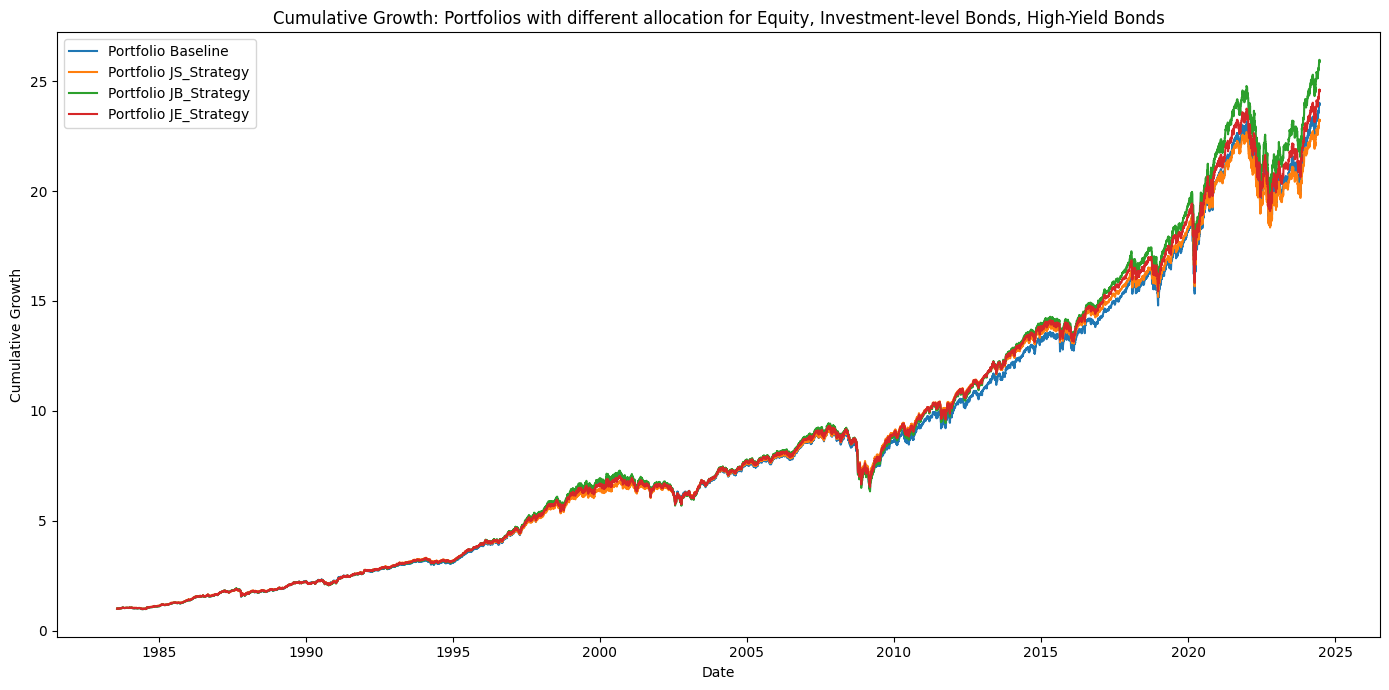

In [10]:
daily_rebalancing_dict = backtest_portfolios_daily(allocations_df, start_date, end_date)

In [11]:
# Iterate over each allocation's returns and calculate performance metrics
performance_metrics = {}
for allocation_name, returns in daily_rebalancing_dict.items():
    performance_metrics[allocation_name] = calculate_performance_metrics(returns)

# Convert the performance metrics dictionary to a DataFrame
performance_df = pd.DataFrame(performance_metrics, index=['Total Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown', 'Max Drawdown Date']).T

# Print the DataFrame
performance_df

,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Max Drawdown Date
Baseline,22.965764,0.056554,0.076532,0.73896,-0.299707,2009-03-09
JS_Strategy,22.220781,0.055105,0.063592,0.866547,-0.2653,2009-03-09
JB_Strategy,24.927154,0.057928,0.077128,0.751065,-0.327925,2009-03-09
JE_Strategy,23.581443,0.056517,0.070252,0.804487,-0.29682,2009-03-09


### Rebalance With Customized Frequency

##### Monthly

In [12]:
def backtest_portfolios(allocations_df, backtest_start_date, backtest_end_date, spy=equity, jnk=highyield, agg=safebond, rebalance_freq='M'):
    cumulative_product_dict = {}
    portfolio_daily_returns_dict = {}

    for allocation_name in allocations_df.columns[2:]:  # Skip 'Asset' and 'ETFs' columns
        # Extract the allocation values from allocations_df
        allocations = {
            'Equities': allocations_df.loc[allocations_df['Asset'] == 'Equities', allocation_name].values[0],
            'HighYieldBonds': allocations_df.loc[allocations_df['Asset'] == 'HighYieldBonds', allocation_name].values[0],
            'InvGradeBonds': allocations_df.loc[allocations_df['Asset'] == 'InvGradeBonds', allocation_name].values[0]
        }

        agg.ffill(inplace=True)
        jnk.ffill(inplace=True)
        spy.ffill(inplace=True)
        # Filter the data for the backtest period
        agg_backtest = agg[(agg['Dates'] >= backtest_start_date) & (agg['Dates'] <= backtest_end_date)].set_index('Dates')
        jnk_backtest = jnk[(jnk['Dates'] >= backtest_start_date) & (jnk['Dates'] <= backtest_end_date)].set_index('Dates')
        spy_backtest = spy[(spy['Dates'] >= backtest_start_date) & (spy['Dates'] <= backtest_end_date)].set_index('Dates')

        # Align the indices
        combined_index = agg_backtest.index.intersection(jnk_backtest.index).intersection(spy_backtest.index)
        agg_backtest = agg_backtest.loc[combined_index]
        jnk_backtest = jnk_backtest.loc[combined_index]
        spy_backtest = spy_backtest.loc[combined_index]

        # Initialize portfolio values and weights
        portfolio_value = 1.0
        portfolio_values = [portfolio_value]
        portfolio_daily_returns = []

        # Initialize weights
        weights = np.array([allocations['Equities'], allocations['HighYieldBonds'], allocations['InvGradeBonds']])

        # Rebalance dates based on the specified frequency
        rebalance_dates = pd.date_range(start=backtest_start_date, end=backtest_end_date, freq=rebalance_freq)

        for i, date in enumerate(combined_index):
            if date in rebalance_dates:
                # Rebalance the portfolio
                total_value = (
                    weights[0] * spy_backtest.loc[date]['LAST_PRICE'] +
                    weights[1] * jnk_backtest.loc[date]['LAST_PRICE'] +
                    weights[2] * agg_backtest.loc[date]['LAST_PRICE']
                )
                weights = np.array([
                    allocations['Equities'] * total_value / spy_backtest.loc[date]['LAST_PRICE'],
                    allocations['HighYieldBonds'] * total_value / jnk_backtest.loc[date]['LAST_PRICE'],
                    allocations['InvGradeBonds'] * total_value / agg_backtest.loc[date]['LAST_PRICE']
                ])
                weights /= weights.sum()  # Normalize weights to sum to 1

            if i > 0:  # Skip the first day
                # Calculate portfolio return
                daily_returns = np.array([
                    spy_backtest.loc[date]['DailyReturn'],
                    jnk_backtest.loc[date]['DailyReturn'],
                    agg_backtest.loc[date]['DailyReturn']
                ])
                portfolio_return = np.dot(weights, daily_returns)
                portfolio_value *= (1 + portfolio_return)

                portfolio_values.append(portfolio_value)
                portfolio_daily_returns.append(portfolio_return)

        cumulative_product_dict[allocation_name] = pd.Series(portfolio_values, index=[pd.to_datetime(backtest_start_date)] + list(combined_index[1:]))
        portfolio_daily_returns_dict[allocation_name] = pd.Series(portfolio_daily_returns, index=combined_index[1:])

    # Plot all cumulative returns on the same plot
    plt.figure(figsize=(14, 7))
    for allocation_name, cumulative_product in cumulative_product_dict.items():
        plt.plot(cumulative_product.index, cumulative_product, label=f'Portfolio {allocation_name}')
    plt.title('Cumulative Growth: Portfolios with different allocation for Equity, Investment-level Bonds, High-Yield Bonds')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Growth')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return cumulative_product_dict 
    # return portfolio_daily_returns_dict, cumulative_product_dict, portfolio_values

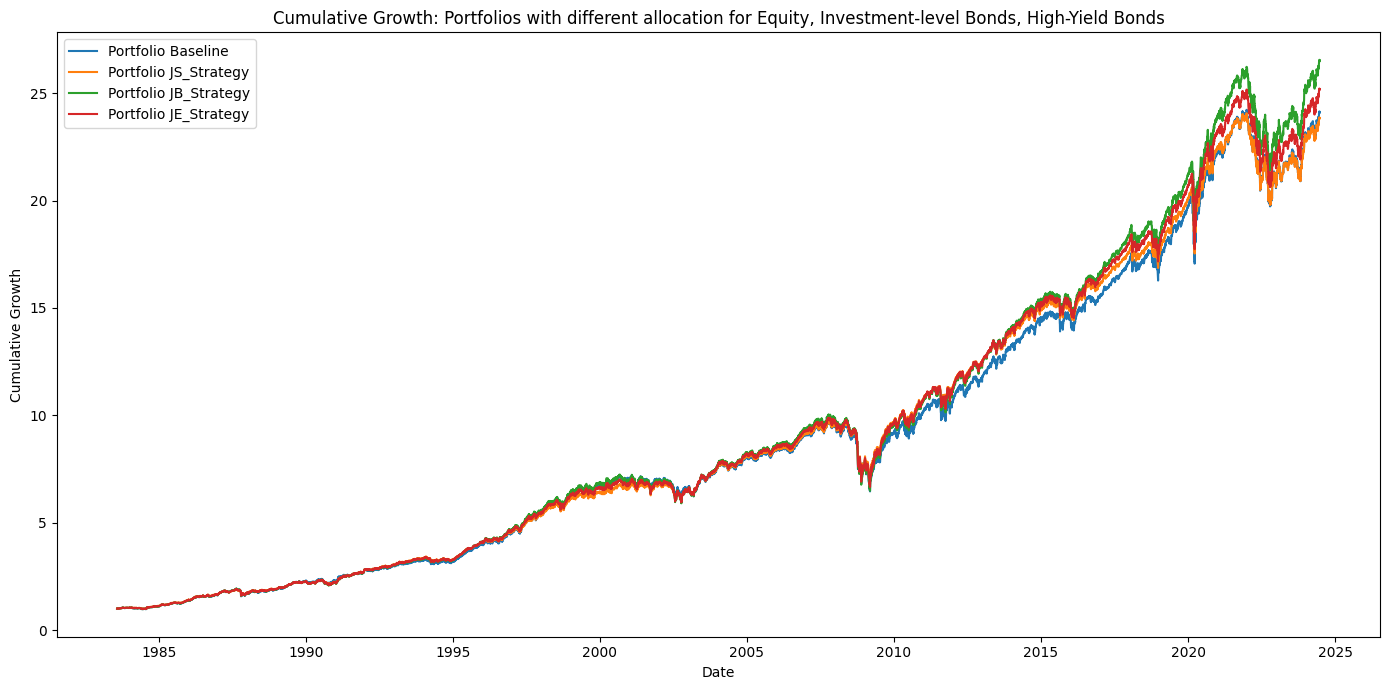

In [13]:
monthly_rebalancing_dict = backtest_portfolios(allocations_df, start_date, end_date, rebalance_freq='M')

In [14]:
# Iterate over each allocation's returns and calculate performance metrics
monthly_performance_metrics = {}
for allocation_name, returns in monthly_rebalancing_dict.items():
    monthly_performance_metrics[allocation_name] = calculate_performance_metrics(returns)

# Convert the performance metrics dictionary to a DataFrame
monthly_performance_df = pd.DataFrame(monthly_performance_metrics, index=['Total Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown', 'Max Drawdown Date']).T

# Print the DataFrame
monthly_performance_df

,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Max Drawdown Date
Baseline,23.116979,0.056682,0.077177,0.734437,-0.336448,2009-03-09
JS_Strategy,22.847339,0.055415,0.061731,0.897698,-0.297619,2009-03-09
JB_Strategy,25.523506,0.058056,0.074137,0.783098,-0.353388,2009-03-09
JE_Strategy,24.189519,0.056737,0.067842,0.836306,-0.325929,2009-03-09


#### Semi-Annually

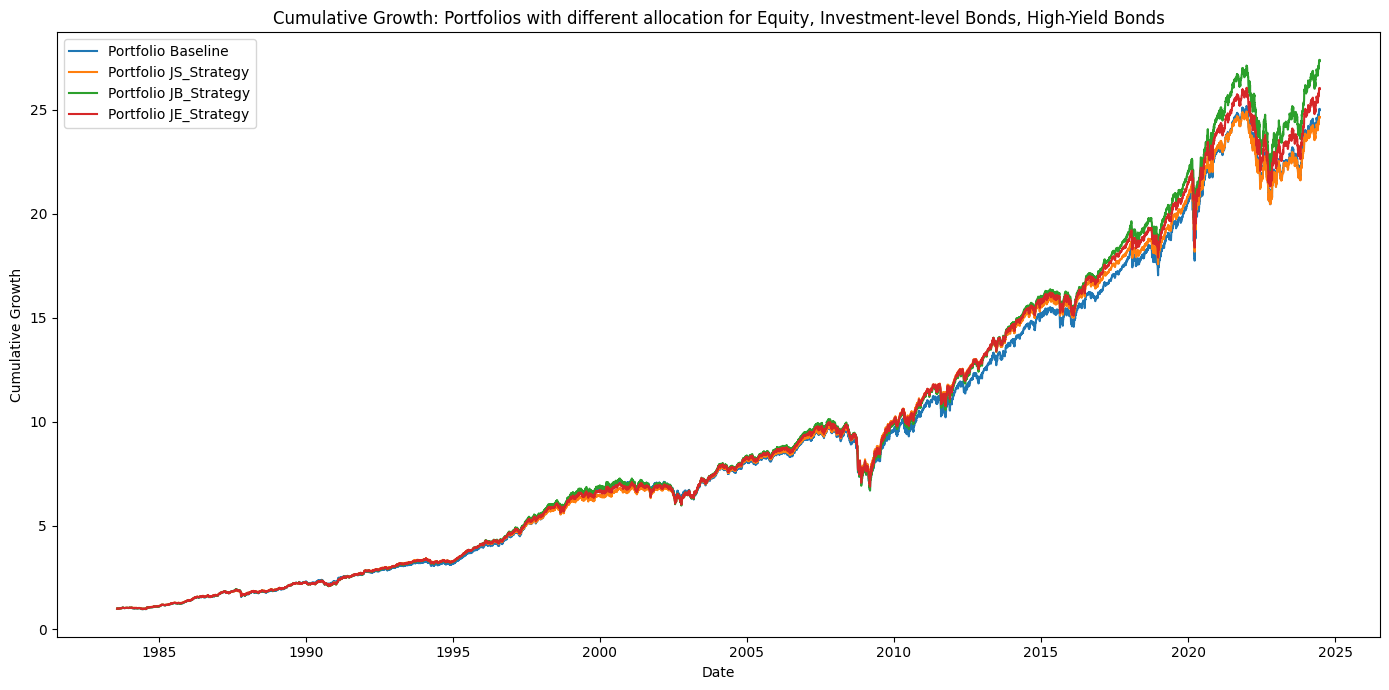

In [15]:
semi_annual_rebalancing_dict = backtest_portfolios(allocations_df, start_date, end_date, rebalance_freq='6M')

In [16]:
# Iterate over each allocation's returns and calculate performance metrics
semi_annual_performance_metrics = {}
for allocation_name, returns in semi_annual_rebalancing_dict.items():
    semi_annual_performance_metrics[allocation_name] = calculate_performance_metrics(returns)

# Convert the performance metrics dictionary to a DataFrame
semi_annual_performance_df = pd.DataFrame(semi_annual_performance_metrics, index=['Total Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown', 'Max Drawdown Date']).T

# Print the DataFrame
semi_annual_performance_df

,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Max Drawdown Date
Baseline,24.015886,0.057213,0.076058,0.752228,-0.316394,2009-03-09
JS_Strategy,23.654514,0.055926,0.060906,0.918239,-0.280753,2009-03-09
JB_Strategy,26.380694,0.058531,0.073299,0.798521,-0.338227,2009-03-09
JE_Strategy,25.030513,0.057234,0.066998,0.854264,-0.309747,2009-03-09


#### Annually

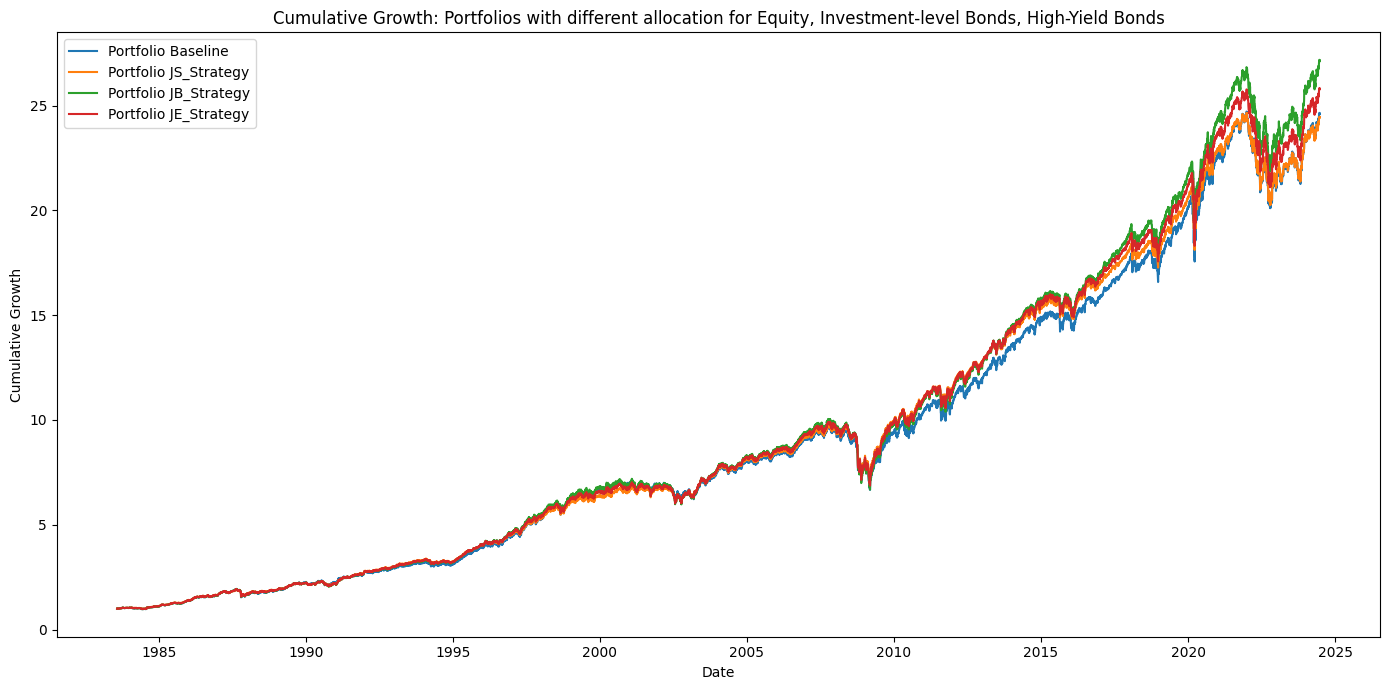

In [17]:
yearly_rebalancing_dict = backtest_portfolios(allocations_df, start_date, end_date, rebalance_freq='Y')

In [18]:
# Iterate over each allocation's returns and calculate performance metrics
yearly_performance_metrics = {}
for allocation_name, returns in yearly_rebalancing_dict.items():
    yearly_performance_metrics[allocation_name] = calculate_performance_metrics(returns)

# Convert the performance metrics dictionary to a DataFrame
yearly_performance_df = pd.DataFrame(yearly_performance_metrics, index=['Total Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown', 'Max Drawdown Date']).T

# Print the DataFrame
yearly_performance_df

,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Max Drawdown Date
Baseline,23.615579,0.056918,0.075704,0.751841,-0.313935,2009-03-09
JS_Strategy,23.441279,0.055756,0.060492,0.921719,-0.27761,2009-03-09
JB_Strategy,26.149999,0.058356,0.072814,0.801437,-0.335172,2009-03-09
JE_Strategy,24.80391,0.057058,0.066544,0.857454,-0.306624,2009-03-09


In [19]:
# Add a column to identify the strategy
performance_df['Strategy'] = 'Buy and Hold'
monthly_performance_df['Strategy'] = 'Monthly Rebalance'
semi_annual_performance_df['Strategy'] = 'Semi-Annual Rebalance'
yearly_performance_df['Strategy'] = 'Annual Rebalance'

# Concatenate the DataFrames
combined_performance_df = pd.concat([performance_df, monthly_performance_df, semi_annual_performance_df, yearly_performance_df])

# Reset the index to have a clean DataFrame
combined_performance_df.reset_index(inplace=True)

combined_performance_df.head(5)

,index,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Max Drawdown Date,Strategy
0,Baseline,22.965764,0.056554,0.076532,0.73896,-0.299707,2009-03-09,Buy and Hold
1,JS_Strategy,22.220781,0.055105,0.063592,0.866547,-0.2653,2009-03-09,Buy and Hold
2,JB_Strategy,24.927154,0.057928,0.077128,0.751065,-0.327925,2009-03-09,Buy and Hold
3,JE_Strategy,23.581443,0.056517,0.070252,0.804487,-0.29682,2009-03-09,Buy and Hold
4,Baseline,23.116979,0.056682,0.077177,0.734437,-0.336448,2009-03-09,Monthly Rebalance


In [20]:
# # Convert to percentage and add percent sign
# combined_performance_df['Annualized Return'] = (combined_performance_df['Annualized Return'].astype(float) * 100).round(2).astype(str) + '%'
# combined_performance_df['Annualized Volatility'] = (combined_performance_df['Annualized Volatility'].astype(float) * 100).round(2).astype(str) + '%'
# combined_performance_df['Max Drawdown'] = (combined_performance_df['Max Drawdown'].astype(float) * 100).round(2).astype(str) + '%'

# combined_performance_df.head(5)

In [21]:
def enhanced_bar_plot(x, y, data, hue='index', palette='viridis', title='Comparison Across Strategies', ylabel='Value'):
    plt.figure(figsize=(14, 8))
    sns.set(style="whitegrid")

    # Create the bar plot
    bar_plot = sns.barplot(x=x, y=y, hue=hue, data=data, palette=palette)

    # Add value labels to each bar
    for p in bar_plot.patches:
        height = p.get_height()
        if height != 0:  # Annotate bars with height not equal to 0
            bar_plot.annotate(format(height, '.2f'), 
                              (p.get_x() + p.get_width() / 2., height), 
                              ha='center', va='center', 
                              xytext=(0, 9 if height > 0 else -9),  # Adjust text position based on height
                              textcoords='offset points')

    # Customize the title and labels
    plt.title(title, fontsize=18, fontweight='bold')
    plt.xlabel(xlabel ='', fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    bar_plot.set_xticklabels(bar_plot.get_xticklabels(), fontsize= 13)
    plt.legend(title='Allocation', title_fontsize='12', fontsize='11', loc='center left', bbox_to_anchor=(1, 0.5))
    # Improve layout
    plt.tight_layout()

    # Show the plot
    plt.show()

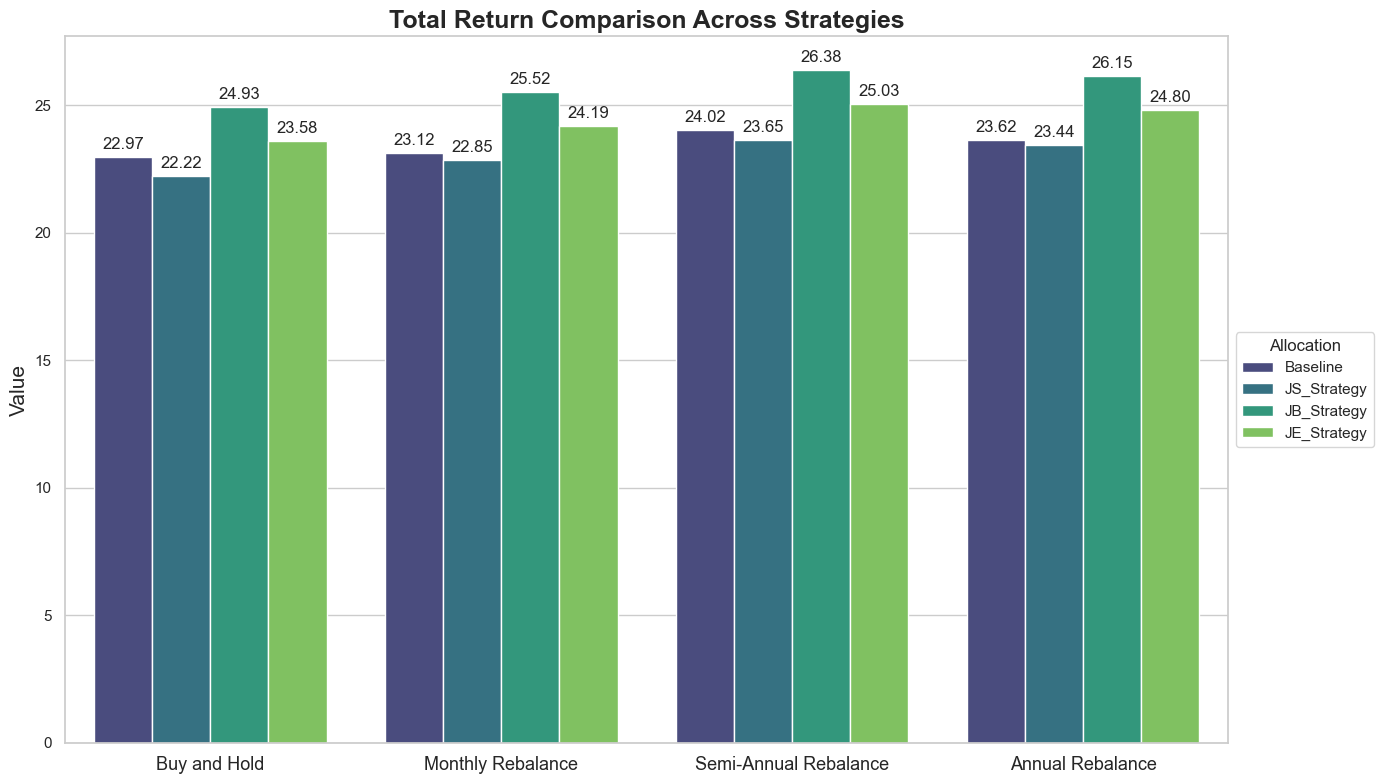

In [22]:
enhanced_bar_plot(x='Strategy', y='Total Return', title='Total Return Comparison Across Strategies', data=combined_performance_df)
# enhanced_bar_plot(x='Strategy', y='Annualized Return', title='Annualized Return Comparison Across Strategies', data=combined_performance_df)
# enhanced_bar_plot(x='Strategy', y='Annualized Volatility', title='Annualized Volatility Comparison Across Strategies', data=combined_performance_df)
# enhanced_bar_plot(x='Strategy', y='Sharpe Ratio', title='Sharpe Ratio Comparison Across Strategies', data=combined_performance_df)
# enhanced_bar_plot(x='Strategy', y='Max Drawdown', title='Max Drawdown Comparison Across Strategies', data=combined_performance_df)

In [23]:
def pct_enhanced_bar_plot(x, y, data, hue='index', palette='viridis', title='Comparison Across Strategies', ylabel='Value'):
    plt.figure(figsize=(14, 8))
    sns.set(style="whitegrid")

    # Create the bar plot
    bar_plot = sns.barplot(x=x, y=y, hue=hue, data=data, palette=palette)

    # Add value labels to each bar
    for p in bar_plot.patches:
        height = p.get_height()
        if height != 0:  # Annotate bars with height not equal to 0
            bar_plot.annotate(f'{height * 100:.2f}%',  # Convert to percentage and format
                              (p.get_x() + p.get_width() / 2., height), 
                              ha='center', va='center', 
                              xytext=(0, 9 if height > 0 else -9),  # Adjust text position based on height
                              textcoords='offset points')

    # Customize the title and labels
    plt.title(title, fontsize=18, fontweight='bold')
    plt.xlabel(xlabel ='', fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    bar_plot.set_xticklabels(bar_plot.get_xticklabels(), fontsize= 13)
    plt.legend(title='Allocation', title_fontsize='12', fontsize='11', loc='center left', bbox_to_anchor=(1, 0.5))
    # Improve layout
    plt.tight_layout()

    # Show the plot
    plt.show()

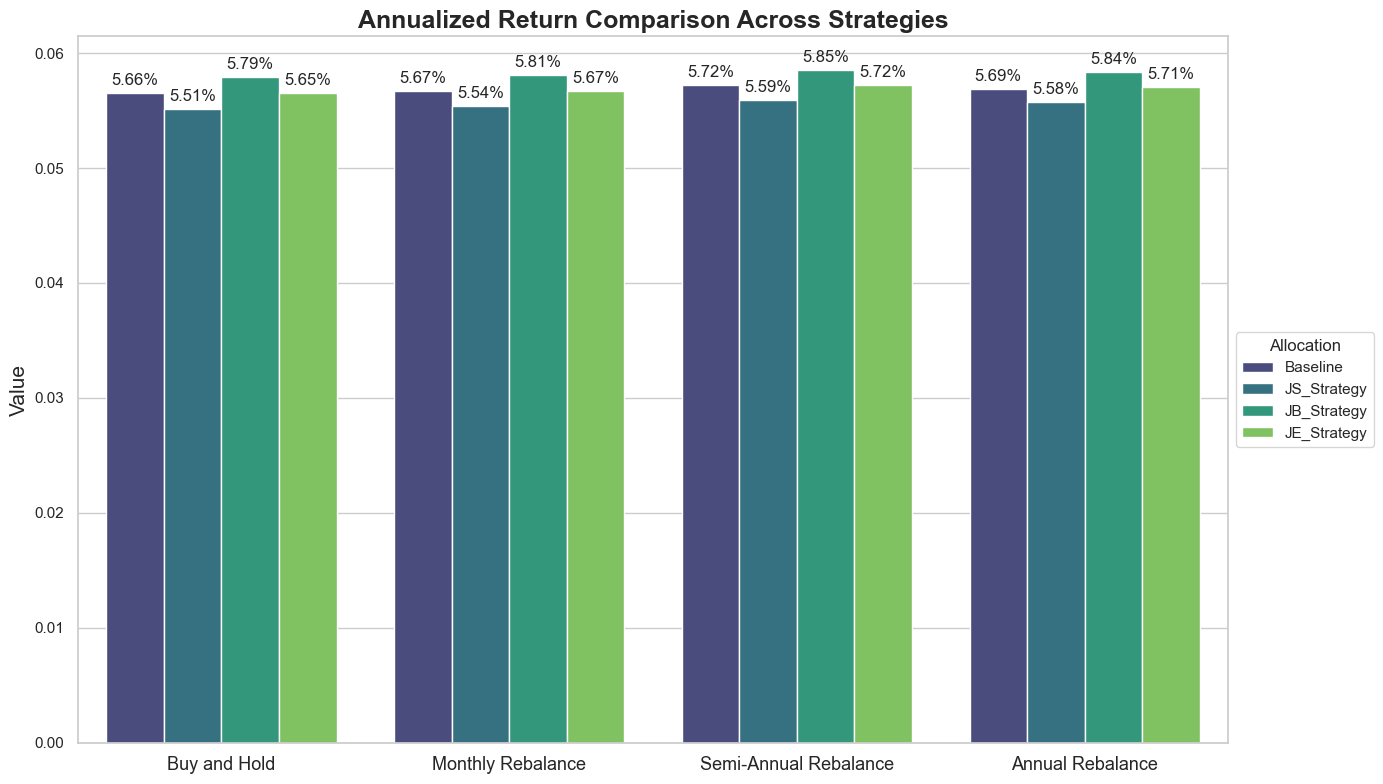

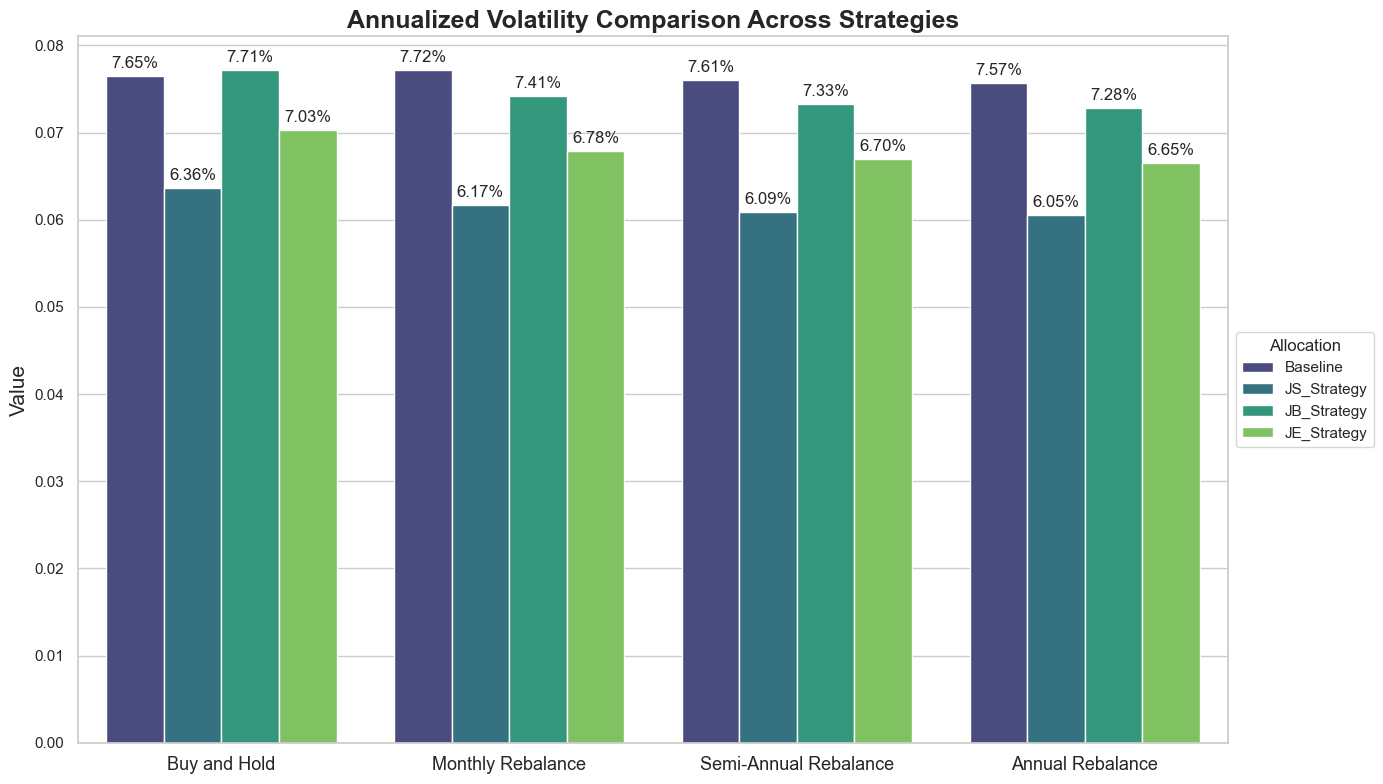

In [24]:
pct_enhanced_bar_plot(x='Strategy', y='Annualized Return', title='Annualized Return Comparison Across Strategies', data=combined_performance_df)
pct_enhanced_bar_plot(x='Strategy', y='Annualized Volatility', title='Annualized Volatility Comparison Across Strategies', data=combined_performance_df)

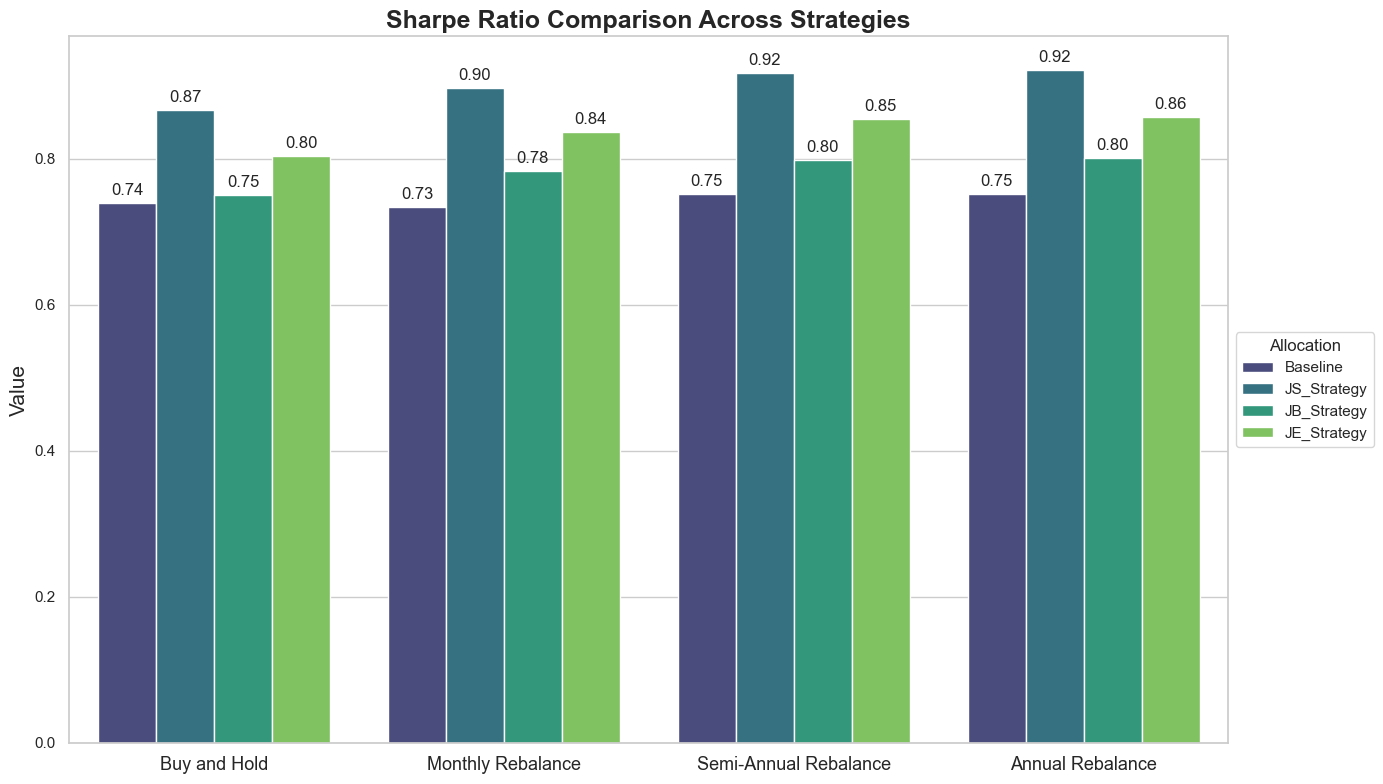

In [25]:
enhanced_bar_plot(x='Strategy', y='Sharpe Ratio', title='Sharpe Ratio Comparison Across Strategies', data=combined_performance_df)

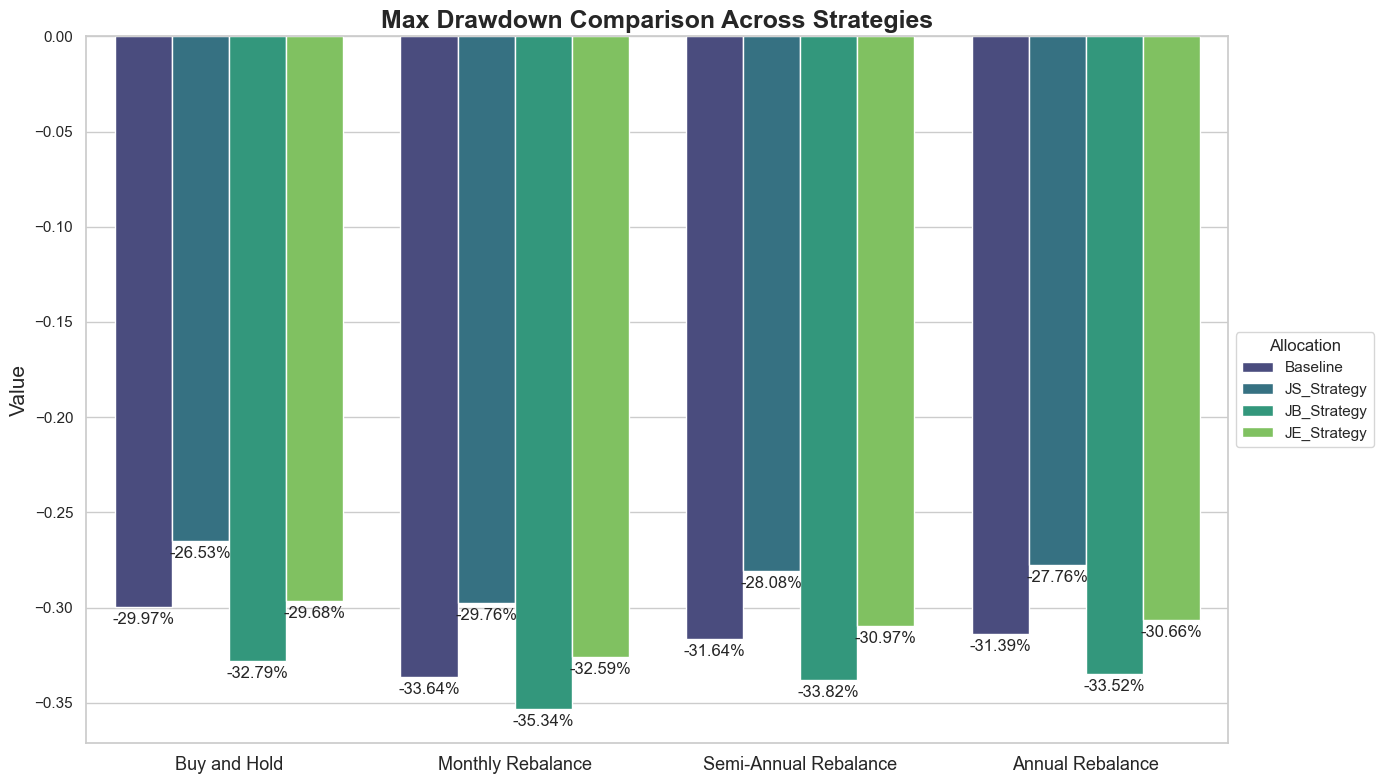

In [26]:
pct_enhanced_bar_plot(x='Strategy', y='Max Drawdown', title='Max Drawdown Comparison Across Strategies', data=combined_performance_df)

##### Baseline Strategy
'Equities': 0.50, 'HighYieldBonds': 0.00, 'InvGradeBonds': 0.50

##### JS Strategy
'Equities': 0.40, 'HighYieldBonds': 0.10, 'InvGradeBonds': 0.50

##### JB Strategy
'Equities': 0.50, 'HighYieldBonds': 0.10, 'InvGradeBonds': 0.40

##### JE Strategy
'Equities': 0.45, 'HighYieldBonds': 0.10, 'InvGradeBonds': 0.45